In [168]:
# 设置数据集名称
dataset_name = ['LUAD']
# 设置俩： ['LUAD', 'LUSC']
# 单一个： ['LUAD']
method = 'normal'  # diff是上面俩数据集的差异，normal是和正常样本的差异
# method = 'diff'


In [169]:
from sklearn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet, ElasticNetCV, SGDClassifier, RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import ast
from multiprocessing import Pool, cpu_count
import requests
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from sklearn import datasets
import warnings
import GEOparse
from typing import Tuple, List
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
warnings.filterwarnings('ignore')


In [170]:
def download_and_parse_data(dataset_name):
    pkl_file_path = './datasets/' + 'TCGA-' + \
        dataset_name + '.mirna_transposed.pkl'
    if os.path.exists(pkl_file_path):
        df_t = pd.read_pickle(pkl_file_path)
    else:
        url = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-" + \
            dataset_name + ".mirna.tsv.gz"
        response = requests.get(url)
        os.makedirs('./datasets', exist_ok=True)
        gz_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv.gz'
        with open(gz_file_path, 'wb') as f_out:
            f_out.write(response.content)
        tsv_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv'
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(tsv_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        df = pd.read_csv(tsv_file_path, sep='\t')
        df_t = df.transpose()
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop(df_t.index[0])
        df_t = np.power(2, df_t) - 1
        df_t = df_t.round(4)
        df_t['Status'] = df_t.index.map(
            lambda x: 1 if x.split('-')[3][:2] == '01' else 0)
        df_t = df_t[['Status'] +
                    [col for col in df_t.columns if col != 'Status']]
        df_t.to_pickle(pkl_file_path)
        os.remove(gz_file_path)
        os.remove(tsv_file_path)
    df_t = df_t.apply(pd.to_numeric)
    return df_t


def find_healthy_samples(df):
    healthy_samples_df = df[df['Status'] == 0]
    return healthy_samples_df


if method == "diff":
    dataA = download_and_parse_data(dataset_name[0])
    dataB = download_and_parse_data(dataset_name[1])

    A_up = dataA[dataA['Status'] == 1]
    B_up = dataB[dataB['Status'] == 1]

    B_up['Status'] = 0
    df_transposed = pd.concat([A_up, B_up], ignore_index=True)
elif method == "normal":
    df_transposed = pd.DataFrame()
    for name in dataset_name:
        df_transposed = df_transposed.append(download_and_parse_data(name))
train_data = df_transposed.apply(pd.to_numeric)
# # split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(
    ['Status'], axis=1), train_data['Status'], test_size=0.2, random_state=42)
# # combine test data
train_data = pd.concat([X_test, y_test], axis=1)


In [171]:
# 选择的模型
# 实际输入的模型
feature = ['hsa-mir-182', 'hsa-mir-21', 'hsa-mir-148a', 'hsa-mir-375', 'hsa-mir-143']
weight = [6.0, 9.0, 15.0, 6.0, -2.0]
threshold = 2135474.1


# 画每个的数据


In [172]:
# 仅选择特征和最终结果. 输出末2行
ID = feature.copy()
ID = np.array(ID).reshape(-1)
# 加('Status')
ID = np.append(ID, ['Status'])
ID.astype('str')
testdata = train_data[ID]
# 把testdata的columns的名字改成feature
testdata.columns = feature + ["target"]
testdata.tail(2)
# 计算每一种基因在不同感染情况下的表达量的平均值
# weight 的最后一位是target，不需要计算，设置为1
weight = np.array(weight).reshape(-1)
weight = np.append(weight, [1])
testdata_mean = testdata * weight
weight = weight.reshape(-1)
weight = weight[:-1]
# testdata_mean
# 计算每一行的和，要去掉最后一列
testdata_mean['sum'] = (testdata_mean.sum(axis=1) - testdata_mean['target'])
zipped = zip(weight, feature)
# select weight > 0
feature_pos = [x for x in zipped if x[0] > 0]
feature_pos = [x[1] for x in feature_pos]
# Assuming testdata_mean is a pandas DataFrame
testdata_mean['pos_sum'] = testdata_mean[feature_pos].sum(axis=1)
# neg
testdata_mean['neg_sum'] = testdata_mean['pos_sum'] - testdata_mean['sum']
# error
testdata_mean['error_indices'] = ((testdata_mean['pos_sum'] - testdata_mean['neg_sum'] - threshold > 0) & (testdata_mean['target'] == 0)) | (
    (testdata_mean['pos_sum'] - testdata_mean['neg_sum'] - threshold < 0) & (testdata_mean['target'] == 1))


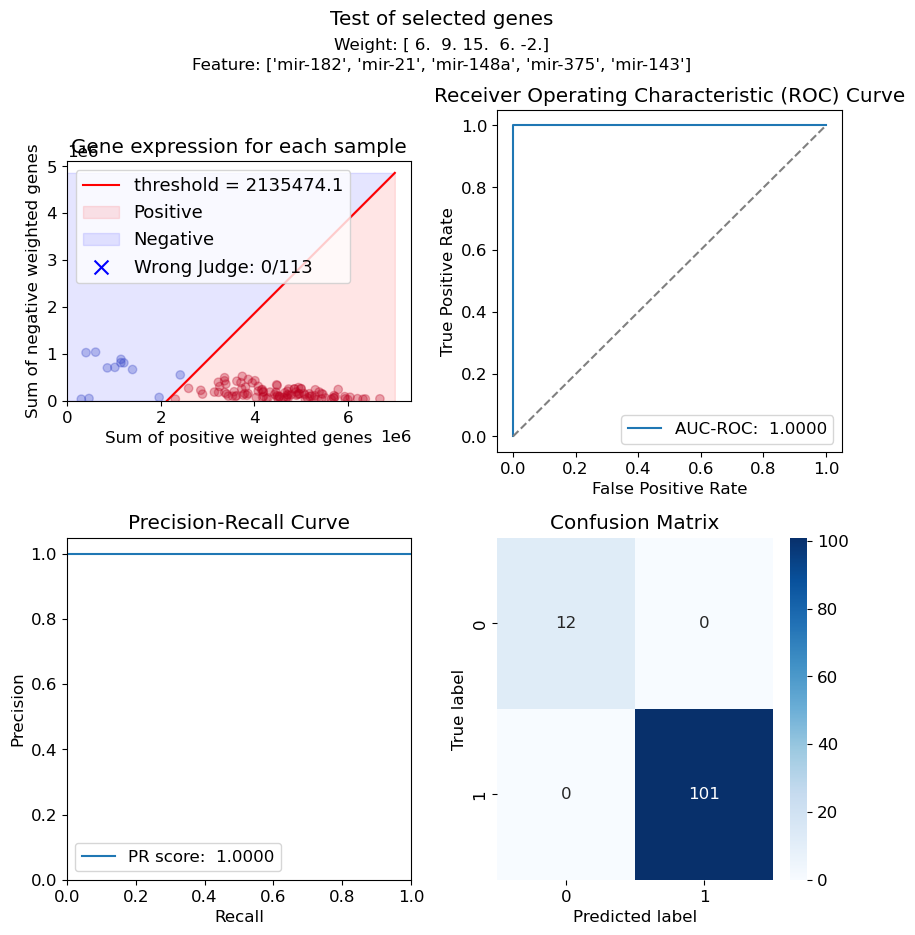

In [173]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust( wspace=0.25, hspace=0.25)

# 1. 错误点标注图
axs[0, 0].scatter(testdata_mean['pos_sum'], testdata_mean['neg_sum'],
                  c=testdata_mean['target'], cmap='coolwarm', alpha=0.3)
axs[0, 0].set_xlabel('Sum of positive weighted genes')
axs[0, 0].set_ylabel('Sum of negative weighted genes')
axs[0, 0].set_title('Gene expression for each sample')
axs[0, 0].set_aspect('equal')

# 首先获取x轴的范围
x_vals = np.array(axs[0, 0].get_xlim())

# 如果threshold > 0，x_vals从threshold开始
if threshold > 0:
    x_vals = np.maximum(x_vals, threshold)

y_vals = x_vals - threshold
axs[0, 0].plot(x_vals, y_vals, color='red', label=f'threshold = {threshold}')
axs[0, 0].fill_between(x_vals, y_vals, axs[0, 0].get_ylim()[
                       0], color='red', alpha=0.1, label='Positive')
axs[0, 0].fill_betweenx(y_vals, x_vals, 0, color='blue',
                        alpha=0.1, label='Negative')

axs[0, 0].set_xlim(0, axs[0, 0].get_xlim()[1])
axs[0, 0].set_ylim(0, axs[0, 0].get_ylim()[1])
num_errors = len(testdata_mean['pos_sum'][testdata_mean['error_indices']])

axs[0, 0].scatter(testdata_mean['pos_sum'][testdata_mean['error_indices']], testdata_mean['neg_sum']
                  [testdata_mean['error_indices']], color='b', marker='x', s=100, label=f'Wrong Judge: {num_errors}/{len(testdata_mean)}')
axs[0, 0].legend(fontsize=13)
axs[0, 0].ticklabel_format(style='sci', scilimits=(0, 0))
axs[0, 0].set_aspect('equal')

# 2. AUC-ROC
fpr, tpr, thresholds = roc_curve(
    testdata_mean['target'], testdata_mean['pos_sum'] - testdata_mean['neg_sum'])
auc_roc = roc_auc_score(
    testdata_mean['target'], testdata_mean['pos_sum'] - testdata_mean['neg_sum'])

axs[0, 1].plot(fpr, tpr, label=f'AUC-ROC: {auc_roc: .4f}')
axs[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0, 1].legend()

# 3. PR
precision, recall, thresholds = precision_recall_curve(
    testdata_mean['target'], testdata_mean['pos_sum'] - testdata_mean['neg_sum'])
auc_pr = average_precision_score(
    testdata_mean['target'], testdata_mean['pos_sum'] - testdata_mean['neg_sum'])

axs[1, 0].plot(recall, precision, label=f'PR score: {auc_pr: .4f}')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].set_title('Precision-Recall Curve')
axs[1, 0].set_ylim([0.0, 1.05])
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].legend()

# 4. confusion_matrix
predictions = (testdata_mean['pos_sum'] -
               testdata_mean['neg_sum'] > threshold).astype(int)
confusion = confusion_matrix(testdata_mean['target'], predictions)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=axs[1, 1])
axs[1, 1].set_xlabel('Predicted label')
axs[1, 1].set_ylabel('True label')
axs[1, 1].set_title('Confusion Matrix')


fig.suptitle('Test of selected genes')

fig.text(0.5, 0.94, f'Weight: {weight}', ha='center')
feature_paint = [feature_.replace('hsa-', '') for feature_ in feature]
fig.text(0.5, 0.92, f'Feature: {feature_paint}', ha='center')

fig.patch.set_alpha(0)  # type: ignore it is to remove the background
# svg
fig.savefig(f'./output/{dataset_name}_{weight}_{feature_paint}.svg',
            bbox_inches='tight', transparent=True)
plt.show()


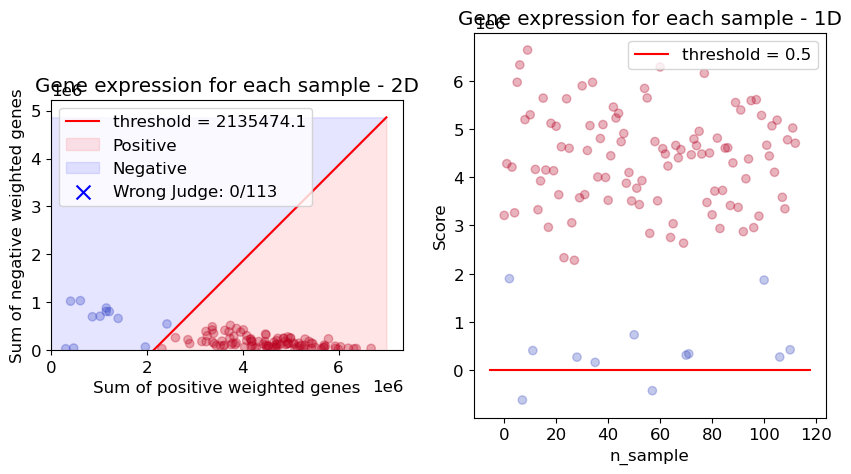

In [174]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 1. 错误点标注图
axs[0].scatter(testdata_mean['pos_sum'], testdata_mean['neg_sum'],
               c=testdata_mean['target'], cmap='coolwarm', alpha=0.3)
axs[0].set_xlabel('Sum of positive weighted genes')
axs[0].set_ylabel('Sum of negative weighted genes')
axs[0].set_title('Gene expression for each sample - 2D')
axs[0].set_aspect('equal')

x_vals = np.array(axs[0].get_xlim())
y_vals = x_vals - threshold
axs[0].plot(x_vals, y_vals, color='red', label=f'threshold = {threshold}')
axs[0].fill_between(x_vals, y_vals, axs[0].get_ylim()[0],
                    color='red', alpha=0.1, label='Positive')
axs[0].fill_betweenx(y_vals, x_vals, 0, color='blue',
                     alpha=0.1, label='Negative')

axs[0].set_xlim(0, axs[0].get_xlim()[1])
axs[0].set_ylim(0, axs[0].get_ylim()[1])
num_errors = len(testdata_mean['pos_sum'][testdata_mean['error_indices']])

axs[0].scatter(testdata_mean['pos_sum'][testdata_mean['error_indices']], testdata_mean['neg_sum']
               [testdata_mean['error_indices']], color='b', marker='x', s=100, label=f'Wrong Judge: {num_errors}/{len(testdata_mean)}')
axs[0].legend()

# 1
axs[1].scatter(range(len(testdata_mean)), testdata_mean['pos_sum'] -
               testdata_mean['neg_sum'], c=testdata_mean['target'], cmap='coolwarm', alpha=0.3)
axs[1].set_xlabel('n_sample')
axs[1].set_ylabel('Score')
axs[1].set_title('Gene expression for each sample - 1D')

# plot y = threshold
threshold2 = 0.5
axs[1].plot(axs[1].get_xlim(), [threshold2, threshold2],
            color='red', label=f'threshold = {threshold2}')

num_errors = len(testdata_mean['pos_sum'][testdata_mean['error_indices']])
axs[1].legend()


## 画分布图


In [175]:
mean = train_data.groupby("Status").mean()

# mean only keep which in feature
mean = mean[feature]


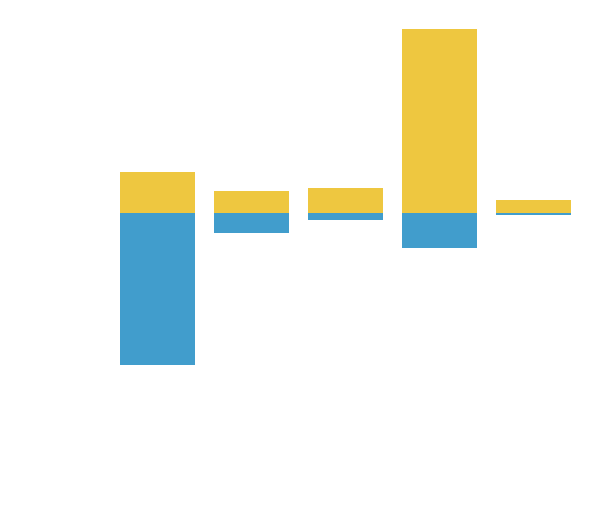

In [176]:
times = mean.iloc[0] / mean.iloc[1]
times = pd.concat([times, mean.T], axis=1)
times.columns = ['times', '0', '1']
# if 0 and 1 are both 0, then remove the row
times = times[times['times'] > 0]
# and not infinity
times = times[times['times'] < 100000]
times = times[times['0'] > 1]
times = times[times['1'] > 1]
# sort by times
times = times.sort_values(by=['times'], ascending=False)
times = pd.concat([times.head(30), times.tail(30)])
fig, ax = plt.subplots()
ax.bar(times.index, times['1'], color='#eec740')
ax.bar(times.index, -times['0'], color='#419dcc')
# background color
# ax.set_facecolor('#142235')
# 外部透明
fig.patch.set_alpha(0)
# 标注字体颜色白色
ax.tick_params(colors='white')
# 内部透明
ax.patch.set_alpha(0)
# 线框颜色 白色
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')

# log scale
# ax.set_yscale('symlog')
# 文字方向
plt.xticks(rotation=90)
# 导出图片为svg
fig.savefig('./output/' + '-'.join(dataset_name) + '.svg', transparent=True)
# show image
plt.show()
